/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:965: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py (987)

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py", line 987:
def histogram(data, bins, range_hist=None):
    <source elided>
    """
    hist, bin_edges = np.histogram(data, bins=bins, range=range_hist)
    ^

  @conditional_jit(cache=True)
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "histogram" was compiled in object mode without forceobj=True.

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py", line 966:
@conditional_jit(cache=True)
def histogram(data, bins, range_hist=None):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packag

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means[0]  52.151  5.320  46.325   57.669      3.742    3.165       3.0   
means[1]  52.143  5.333  46.304   57.684      3.751    3.172       3.0   
p[0]       0.500  0.410   0.076    0.922      0.289    0.244       3.0   
p[1]       0.500  0.410   0.078    0.924      0.289    0.244       3.0   

          ess_tail  r_hat  
means[0]      60.0   1.83  
means[1]      73.0   1.83  
p[0]          78.0   1.83  
p[1]          78.0   1.83  


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 cha

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means[0]  46.828  0.423  46.085   47.622      0.010    0.007    1852.0   
means[1]  57.467  0.098  57.293   57.659      0.002    0.002    2019.0   
p[0]       0.090  0.009   0.073    0.106      0.000    0.000    1718.0   
p[1]       0.910  0.009   0.894    0.927      0.000    0.000    1718.0   

          ess_tail  r_hat  
means[0]    1265.0    1.0  
means[1]    1534.0    1.0  
p[0]        1480.0    1.0  
p[1]        1480.0    1.0  


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


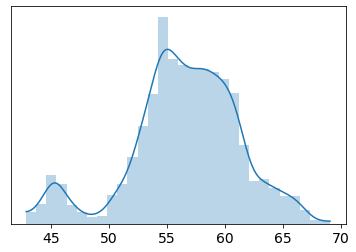

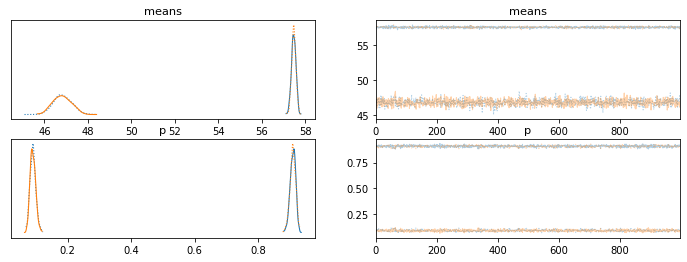

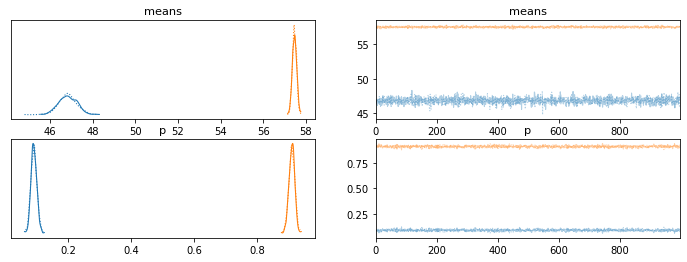

In [2]:

# Gaussian mixture model suign PyMC3
# Based on https://github.com/aloctavodia/BAP/blob/master/code/Chp6/06_mixture_models.ipynb


try:
    import pymc3 as pm
except ModuleNotFoundError:
    %pip install pymc3
    import pymc3 as pm
import numpy as np
import scipy.stats as stats

try:
    import pandas as pd
except ModuleNotFoundError:
    %pip install pandas
    import pandas as pd
try:
    import theano.tensor as tt
except ModuleNotFoundError:
    %pip install theano
    import theano.tensor as tt
import matplotlib.pyplot as plt

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install arviz
    import arviz as az
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

np.random.seed(42)


# url = 'https://github.com/aloctavodia/BAP/tree/master/code/data/chemical_shifts_theo_exp.csv?raw=true'
# There is some error reading the abvoe file
# Error tokenizing data. C error: Expected 1 fields in line 71, saw 2
# So we make a copy here
url = "https://raw.githubusercontent.com/aloctavodia/BAP/master/code/data/chemical_shifts_theo_exp.csv"
df = pd.read_csv(url)
obs = df["exp"]

az.plot_kde(obs)
plt.hist(obs, density=True, bins=30, alpha=0.3)
plt.yticks([])
pml.savefig("gmm_pymc3_data.pdf", dpi=300)

# Illustrate unidentifiability

clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal("means", mu=obs.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)
    y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=obs)
    trace_mg = pm.sample(random_seed=123, cores=1, chains=2)

varnames = ["means", "p"]
print(az.summary(trace_mg, varnames))

az.plot_trace(trace_mg, varnames)
pml.savefig("gmm_pymc3_label_switching.pdf", dpi=300)

# Add constraint that mu[0] < mu[1] using a potential (penalty) function

clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal("means", mu=np.array([0.9, 1]) * obs.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)
    order_means = pm.Potential("order_means", tt.switch(means[1] - means[0] < 0, -np.inf, 0))
    y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=obs)
    trace_mgp = pm.sample(1000, random_seed=123, cores=1, chains=2)

varnames = ["means", "p"]
print(az.summary(trace_mgp, varnames))
az.plot_trace(trace_mgp, varnames)
pml.savefig("gmm_pymc3_constrained.pdf", dpi=300)

plt.show()